In [14]:
# A notebook to figure out why two tracks were not merged.
# It could not find the track by color!!!!!  No time to debug this more.

from __future__ import division, print_function
from ipywidgets import interact, interactive, fixed, interact_manual    
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp
from scipy import ndimage
from IPython.core.debugger import set_trace
import cv2
import sys
from pprint import pprint
from random import randint
from nuclei.foci import *
import nuclei.girder as g
import nuclei.girder.time_lapse_data as reader

plt.rcParams['image.cmap'] = 'gist_earth'
matplotlib.rcParams['figure.figsize'] = (11.0, 11.0)


# input parameters
czi_folder_id = "5ada43f41fbb9005ff7260eb"
series_idx = 5
color0 = (255, 0, 0)
color1 = (0, 255, 0)
color2 = (248, 31, 232)
time = 51


In [15]:
# This block sets up the reader of a czi folder.
# it then detects rows in the brightfield channel of an image.

# Setup the reader.
source = reader.time_lapse_data()
source.load(czi_folder_id) 
num_series = source.get_number_of_series()
num_time_steps = source.get_series_length(series_idx)
im, item_obj = source.get_image(series_idx,0)

# detect rows of circles.
rows = compute_rows(im)



stack_id = 5ada46ab1fbb9005ff726679
annotation_id = 5adcbcc71fbb9052b6668283
Track (length = 86, color = #f81fe8):
  8: (1190.000000, 132.000000)
  9: (1196.000000, 144.000000)
  10: (1201.000000, 136.000000)
  11: (1201.000000, 134.000000)
  12: (1202.000000, 132.000000)
  13: (1263.000000, 1982.000000)
  14: (1273.000000, 1944.000000)
  15: (1316.000000, 1912.000000)
  16: (1337.000000, 1928.000000)
  17: (1337.000000, 1902.000000)
  18: (1329.000000, 1862.000000)
  19: (1329.000000, 1829.000000)
  20: (1327.000000, 1797.000000)
  21: (1329.000000, 1765.000000)
  22: (1265.000000, 1760.000000)
  23: (1276.000000, 1758.000000)
  24: (1269.000000, 1786.000000)
  25: (1312.000000, 1833.000000)
  26: (1358.000000, 1866.000000)
  27: (1362.000000, 1869.000000)
  28: (1318.000000, 1873.000000)
  29: (1307.000000, 1888.000000)
  30: (1286.000000, 1865.000000)
  31: (1274.000000, 1892.000000)
  32: (1312.000000, 1886.000000)
  33: (1345.000000, 1922.000000)
  34: (1374.000000, 1928.000000)
 

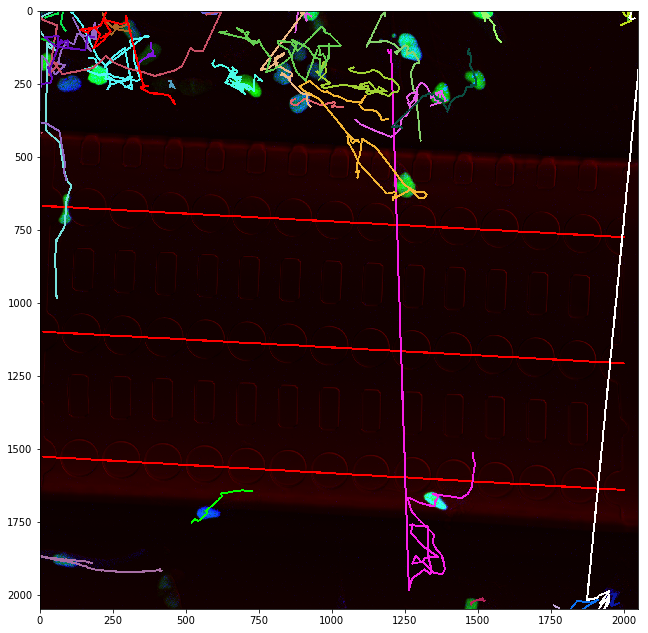

In [16]:
# Load the tracks
# First get the stack id from the source.
stack = source.get_series_stack(series_idx)
print("stack_id = %s"%stack['_id'])


# Get the tracks from the stack item
annotation = g.Annotation("tracks")
annotation.LoadFromItem(stack['_id'])

#pprint(annotation.annot_obj)

tracks = convert_annotation_to_tracks(annotation)

track1 = find_track_by_color(tracks, color0)
track2 = find_track_by_color(tracks, color1)
track3 = find_track_by_color(tracks, color2)

track3.p()


print(rank_merge_tracks(track1, track2, rows))

def test(track1, track2, rows=[]):
    #this returns the max dist between tracks
    # case 1: overlap
    maxdist = -1
    start1 = track1.get_start_time()
    end1 = track1.get_end_time()
    for time in range(start1, end1 + 1):
        ell1 = track1.get_ellipse_from_time(time)
        ell2 = track2.get_ellipse_from_time(time)
        if ell2 != None:
            dist = getDistBtwEll(ell1,ell2, rows)
            if dist > maxdist:
                maxdist = dist
    if maxdist != -1:
        return maxdist

    # handle a gap.  Find the two closest points in time
    start2 = track2.get_start_time()
    end2 = track2.get_end_time()
    if abs(start2 - end1) < abs(start1 - end2):
        t1 = end1
        t2 = start2
    else:
        t2 = end2
        t1 = start1
    if abs(t2-t1) > 2:
        return 99999999
    ell1 = track1.get_ellipse_from_time(t1)
    ell2 = track2.get_ellipse_from_time(t2)

    return getDistBtwEll(ell1,ell2, rows) * abs(t2-t1)*25

print(test(track1, track2, rows))


#track0.p()
#track1.p()


im, item_obj = source.get_image(series_idx,time)
# draw the row
for row in rows:
    cv2.line(im,(10,int(10*row[0]+row[1])),(2000,int(2000*row[0]+row[1])),(255,0,0),5)

# draw the tracks    
for track in tracks:
    track.draw_in_frame(im, time+10)
    
plt.imshow(im)




In [4]:
hex_color = color_to_hex(color0)
colors = [t.color for t in tracks]
print(color0)
print(colors)
print(colors.index(color0))

(255, 0, 0)
[(109, 48, 240), (70, 77, 137), (239, 42, 63), (41, 86, 39), (179, 188, 154), (35, 49, 192), (128, 150, 189), (38, 85, 236), (234, 58, 98), (132, 132, 157), (11, 135, 249), (54, 80, 53), (102, 168, 210), (214, 66, 53), (209, 121, 236), (14, 186, 253), (159, 117, 245), (92, 31, 156), (46, 221, 101), (92, 155, 23), (227, 216, 4), (182, 197, 96), (199, 168, 48), (1, 210, 84), (17, 218, 208), (212, 175, 3), (13, 223, 148), (118, 218, 89), (149, 163, 172), (88, 95, 126), (224, 255, 239), (93, 38, 68), (60, 211, 218), (247, 85, 67), (13, 167, 157), (145, 234, 76), (136, 143, 163), (215, 41, 69), (62, 242, 78), (73, 30, 239), (139, 83, 227), (131, 230, 75), (124, 151, 11), (46, 194, 34), (32, 106, 213), (203, 197, 86), (167, 121, 97), (32, 173, 101), (191, 20, 87), (37, 56, 240), (150, 60, 240), (85, 212, 252), (66, 248, 13), (5, 213, 19), (16, 138, 17), (56, 19, 66), (213, 139, 185), (215, 51, 16), (2, 133, 187), (156, 245, 130), (76, 29, 104), (57, 168, 162), (56, 235, 243), (0,

ValueError: (255, 0, 0) is not in list